This project is an extension of previous IMDB classification. We will try to predict the IMDB score of movies instead of only classify its class. In this project, the same dataset is used before in IDMB classification project. If you want to have detail and descriptions how the dataset is processed please take a look at IMDB_Classification.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

data = pd.read_csv("movie_metadata.csv")
data.drop_duplicates(keep='first', inplace = True)
data = data.reset_index(drop=True)
data = data.drop(["genres","aspect_ratio","plot_keywords","color","movie_title","director_name", "actor_1_name",
                  "actor_2_name", "actor_3_name", "movie_imdb_link","language"], axis = 1)
data = data.dropna(subset = ["budget", "gross"]).reset_index(drop = True)
data = data.dropna(subset = ["content_rating"]).reset_index(drop = True)
data["content_rating"] = data["content_rating"].replace({"M":"PG","GP":"PG", 
                                                         "X":"NC-17",
                                                         "Approved":"R","Not Rated":"R","Passed":"R", "Unrated":"R"})
data["content_rating"] = data["content_rating"].replace({"PG-13": 0,"PG": 1,"G": 2,"R": 3,"NC-17": 4})
data["country"] = data["country"].replace({"USA": 1, "UK": 2})
data["country"] = data["country"].apply(lambda x: 0 if x != 1 and x != 2 else x)
zcount = {}
excluded_col = ["facenumber_in_poster", "country", "content_rating"]
for column in data.columns:
    if column not in excluded_col:
        zcount[column] = (Counter(sorted(data[column]))[0])
data = data.fillna(0.0)
temp = []
for key in zcount.keys():
    if zcount[key] != 0:
        temp.append(key)
for col in temp:
    data[col] = data[col].replace({0.0:data[col].mean()})
data["other_actor_facebook_likes"] = data["actor_3_facebook_likes"] + data["actor_2_facebook_likes"]
data["review_ratio"] = data["num_critic_for_reviews"] / data["num_user_for_reviews"]
data = data.drop(["cast_total_facebook_likes","actor_3_facebook_likes",
                  "actor_2_facebook_likes","num_critic_for_reviews","num_user_for_reviews"], axis = 1)
df = data[['title_year','country','duration', 'budget','gross',
          'review_ratio','num_voted_users','facenumber_in_poster','movie_facebook_likes',
          'director_facebook_likes','actor_1_facebook_likes','other_actor_facebook_likes',
          'imdb_score']]
df

,title_year,country,duration,budget,gross,review_ratio,num_voted_users,facenumber_in_poster,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,other_actor_facebook_likes,imdb_score
0,2009.0,1,178.0,237000000.0,760505847.0,0.236739,886204,0.0,33000.000000,793.408565,1000.000000,1791.000000,7.9
1,2007.0,1,169.0,300000000.0,309404152.0,0.243942,471220,0.0,9195.043615,563.000000,40000.000000,6000.000000,7.1
2,2015.0,2,148.0,245000000.0,200074175.0,0.605634,275868,1.0,85000.000000,793.408565,11000.000000,554.000000,6.8
3,2012.0,1,164.0,250000000.0,448130642.0,0.301000,1144337,0.0,164000.000000,22000.000000,27000.000000,46000.000000,8.5
4,2012.0,1,132.0,263700000.0,73058679.0,0.626016,212204,1.0,24000.000000,475.000000,640.000000,1162.000000,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801,2004.0,1,77.0,7000.0,424760.0,0.385445,72639,0.0,19000.000000,291.000000,291.000000,53.000000,7.0
3802,2005.0,0,80.0,7000.0,70071.0,1.000000,589,0.0,74.000000,793.408565,7640.344982,2731.580137,6.3
3803,1992.0,1,81.0,7000.0,2040920.0,0.430769,52055,0.0,9195.043615,793.408565,121.000000,26.000000,6.9
3804,2011.0,1,95.0,9000.0,4584.0,1.000000,1338,1.0,413.000000,793.408565,296.000000,338.000000,6.4


In [2]:
#Make feature and label data
feature = df.iloc[:,:len(df.columns)-1].values
idmb = df["imdb_score"].values
#Normalizing the feature data
scaler = MinMaxScaler()
X = scaler.fit_transform(feature)
y = idmb
#split dataset into training and testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 5)
result = []

1. Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train, y_train)
regressor.score(x_test, y_test)
print(f'Score of model is {regressor.score(x_test, y_test)}')
result.append(regressor.score(x_test, y_test))

Score of model is 0.35397894607142855


2. K-Nearest Neighbors

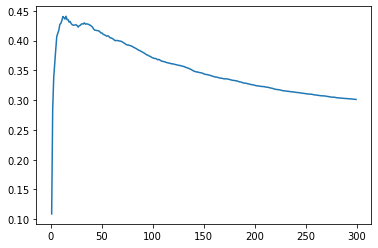

The best score is 0.4408286557490948 with k = 14


In [4]:
from sklearn.neighbors import KNeighborsRegressor
score = []
for k in range(1,300):
    classifier = KNeighborsRegressor(n_neighbors = k, weights = "distance")
    classifier.fit(x_train, y_train)
    score.append(classifier.score(x_test, y_test))
plt.plot(range(1,300),score)
plt.show()
print(f'The best score is {max(score)} with k = {score.index(max(score))}')
result.append(max(score))

3. Support-Vector Regression

In [5]:
from sklearn.svm import SVR

regressor = SVR()
regressor.fit(x_train, y_train)
print(f'Score of model is {regressor.score(x_test, y_test)}')
result.append(regressor.score(x_test, y_test))

Score of model is 0.4387382794485598


4. Decision Tree Regressor

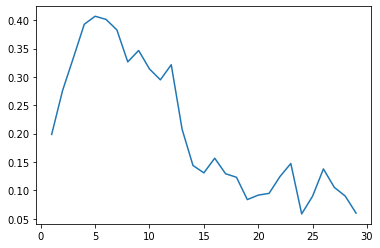

The highest score achieve is 0.4068845207862656 with max_depth of 4


In [6]:
from sklearn.tree import DecisionTreeRegressor
n = 30
score = []
for i in range(1,n):
    regressor = DecisionTreeRegressor(criterion='mae', max_depth = i)
    regressor.fit(x_train, y_train)
    score.append(regressor.score(x_test, y_test))
plt.plot(range(1,n),score)
plt.show()
print(f'The highest score achieve is {max(score)} with max_depth of {score.index(max(score))}')
result.append(max(score))

5. Random Forest Regressor

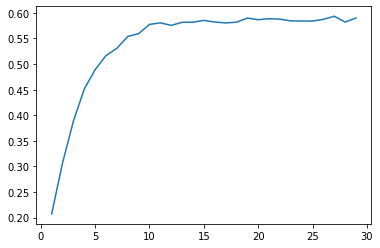

The highest score achieve is 0.5934449955983018 with max_depth of 26


In [7]:
from sklearn.ensemble import RandomForestRegressor
n = 30
score = []
for i in range(1,n):
    regressor = RandomForestRegressor(max_depth = i)    
    regressor.fit(x_train, y_train)
    score.append(regressor.score(x_test, y_test))
    
plt.plot(range(1,n),score)
plt.show()
print(f'The highest score achieve is {max(score)} with max_depth of {score.index(max(score))}')
result.append(max(score))

Conclusion

In [8]:
model_list = ["Linear Regression", "K-Nearest Neighbors Regression", "Support-Vector Regression",
              "Decision Tree Regression", "Random Forest Regression"]
conclusion = pd.DataFrame(result, index = [model_list], columns = ["score"])
conclusion

,score
Linear Regression,0.353979
K-Nearest Neighbors Regression,0.440829
Support-Vector Regression,0.438738
Decision Tree Regression,0.406885
Random Forest Regression,0.593445


Unlike the previous classification, the score of prediction models is quite low. They are in range from 0.35 to nearly 0.6. Model with the lowest score is Linear Regression as expected and again, random forest regression has the highest score when predicting the IMDB of a movie. This project is an extension of the previous IMDB classification and it is more complex one. However, it is still simple because none of the model can reach the score of 0.7 as our expectation. Further projects should implement other method such as tuning hyperparameter or developing more complex model in order to have more accuracy result.